# Setup for Figure 3 & S4A-C, E (right), G, I (Split Maze)

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
''' Define some functions for later '''
def count_consec(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y - 1:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

def tuning_curve_bytrial(x, trial, Y, dt, b, sigma, smooth=True, normalize=False, occupancy=True):
    '''
    Params
    ------
    x : ndarray
        variable of interest by observation; shape (n_obs, )
    trial : ndarray
        trial num for each observation; shape (n_obs, )
    Y : ndarray
        spikes per observation; shape (n_obs, n_cells)
    dt : int
        time per observation in seconds
    b : int
        bin size
    sigma : int
        SD of Gaussian filter
    smooth : bool
        apply gaussian filter to firing rate; optional, default is True
    normalize : bool
        normalize the firing rate of each cell such that its max FR is 1, min is 0;
        optional, default is False
    occupancy : bool
        return occupancy (dwell time in each bin); optional, default is True

    Returns
    -------
    firing_rate : ndarray
        binned firing rate for each trial for each cell; shape (n_trials, n_bins, n_cells)
    centers : ndarray
        center of each bin
    occ : ndarray
       dwell time in each bin; shape (n_bins, n_cells)
    '''
    edges = np.arange(0, np.max(x) + b, b)
    centers = (edges[:-1] + edges[1:])/2
    b_idx = np.digitize(x, edges)
    if np.max(x) == edges[-1]:
        b_idx[b_idx==np.max(b_idx)] = np.max(b_idx) - 1
    unique_bdx = np.unique(b_idx)

    # find FR in each bin
    firing_rate = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    occ = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    for j in range(unique_bdx.shape[0]):
        idx1 = (b_idx == unique_bdx[j])
        for i, t in enumerate(np.unique(trial)):
            idx = idx1 & (trial == t)
            if np.sum(idx)==0:
                #print('warning: zero occupancy!')
                firing_rate[i, j, :] = firing_rate[i, j-1, :]
                occ[i, j, :] = 0
            else:    
                spike_ct = np.sum(Y[idx, :], axis=0)
                occupancy = dt * np.sum(idx)
                occ[i, j, :] = occupancy
                firing_rate[i, j, :] = spike_ct / occupancy
    if smooth:
        firing_rate = gaussian_filter1d(firing_rate, sigma, axis=1, mode='wrap')

    if normalize:
        for c in range(firing_rate.shape[2]):
            firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))
    
    if occupancy:
        return firing_rate, centers, occ
    else: 
        return firing_rate, centers
    
def find8adjacentElements(test_list):
    ''' 
    Params
    ------
    test_list : ndarray
        1d array to be sorted
    
    Returns
    -------
    neighbors : list
        nested list where each element is a list of 8 adjacent elements to the element with the same 
        index in test_list, adjusting for the first and last four elements and not including 
    '''
    
    neighbors = []
    for idx, ele in enumerate(test_list):
    # Checking for all cases to append
        if idx == 0:
            neighbors.append(test_list[(idx+1):(idx + 9)])
        elif idx == 1:
            neighbors.append(np.concatenate((test_list[(idx - 1)],test_list[(idx+1):(idx + 8)]),axis=None))
        elif idx == 2:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 7)]),axis=None))
        elif idx == 3:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 6)]),axis=None))
        elif idx == len(test_list) - 1:
            neighbors.append(np.concatenate((test_list[(idx-8):idx]),axis=None))                     
        elif idx == len(test_list) - 2:
            neighbors.append(np.concatenate((test_list[(idx-7):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 3:
            neighbors.append(np.concatenate((test_list[(idx-6):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 4:
            neighbors.append(np.concatenate((test_list[(idx-5):idx],test_list[(idx + 1):]),axis = None))
        else:
            neighbors.append(np.concatenate((test_list[(idx - 4):idx],test_list[(idx+1):(idx + 5)]),axis=None))
    return neighbors 

def find(x):
    return x.nonzero()[0]

def circ_autocorr(x):
    Fx = np.fft.fft(x)
    Fxp = np.conj(np.fft.fft(x))
    return np.roll(np.fft.ifft(Fx * Fxp).real, x.size // 2)

def ar1_acf(nt, phi, sigma2):
    """
    Computes the theoretical autocorrelation function for an AR(1) model.
    This serves as our null distribution for computing significance
    
    Params:
    -------
    nt : number of timesteps
    phi : autoregressive coefficient
    sigma2 : variance of gaussian noise
    """
    return (phi ** np.arange(nt)) * sigma2 / (1 - phi ** 2)

def autocorr(x,lags):
    '''numpy.correlate'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

In [4]:
''' Load Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/LocalData/animalmeta.csv')
animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,...,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions,Total_Cells,visualacuity,perchangespeedgain,perchangekurt,perchangeskew,perchangeIQR
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,...,645,3,6,6,1540.0,NaN,17.367862,NaN,NaN,NaN
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,...,645,3,6,6,1574.0,NaN,22.050636,NaN,NaN,NaN
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,...,714,3,6,6,1002.0,NaN,21.328531,NaN,NaN,NaN
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,...,714,3,6,6,985.0,NaN,15.687094,NaN,NaN,NaN
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,...,691,3,6,6,1691.0,NaN,52.102357,NaN,NaN,NaN


In [5]:
'''Find names of specific animals groups'''
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

In [6]:
''' Complete List of Mice & Sessions for Neural Data '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [8]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [9]:
''' Find & save indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded''' 
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/indices/'


for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        #define indices for first two quarters accounting for skipped trials
        start_idx = (np.where(trial >= 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        enda_idx = (np.where(trial <= 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        endb_idx = (np.where(trial <= 139)[0][-1]).astype(int) # last index before alternation
        Aidx = np.arange(start_idx, enda_idx + 1, 1)
        Bidx = np.arange(enda_idx + 1, endb_idx + 1, 1)
        
        #find context A / B trials in alternation, removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
               
        A_trials = np.where((left == 1))[0]
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        B_trials = list(B_trials[B_trials >= 140])
    
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
    
        A_idx = []
        for t in A_trials:
            A_idx = np.append(A_idx, np.where(trial == t)[0])
            A_idx = A_idx.astype(int)
            
        B_idx = []
        for t in B_trials:
            B_idx = np.append(B_idx, np.where(trial == t)[0])
            B_idx = B_idx.astype(int)
            
        #save indices for session section
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx
                
        # get non-gain change A' and B' indices 
        gain = trialinfo['gain']
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            print(str(m) + str(s) + ' did not reach gain change')
            
            d['A_ngidx'] = A_idx
            d['B_ngidx'] = B_idx
            
            continue 
            
        #get count of gain in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)

        Agtrials = np.intersect1d(A_trials, np.asarray(gain_trials))
        Agtrials = list(np.sort(Agtrials.astype(int)))
        Bgtrials = np.intersect1d(B_trials, np.asarray(gain_trials))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #get indices of observations corresponding to the selected trials
        Agidx = []
        for t in Agtrials:
            Agidx = np.append(Agidx, np.where(trial == t)[0])
        Agidx = Agidx.astype(int)
            
        Bgidx = []
        for t in Bgtrials:
            Bgidx = np.append(Bgidx, np.where(trial == t)[0])
        Bgidx = Bgidx.astype(int)
        
        A_ngidx = np.setdiff1d(A_idx,Agidx).astype(int)
        B_ngidx = np.setdiff1d(B_idx,Bgidx).astype(int)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx
        

  0%|          | 0/3 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[ 6  7 83]
Skipped trials, n skipped = 11[ 39  40  41  74  75  76  77  78 108 127 180]
Skipped trials, n skipped = 1[160]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 1[168]
Skipped trials, n skipped = 1[130]
Skipped trials, n skipped = 2[ 29 144]
Skipped trials, n skipped = 4[161 164 165 166]


  0%|          | 0/4 [00:00<?, ?it/s]

Skipped trials, n skipped = 15[100 101 102 110 111 112 113 114 115 116 117 118 119 172 181]
Skipped trials, n skipped = 4[141 188 189 190]
Skipped trials, n skipped = 11[ 82 109 110 130 149 150 157 169 170 178 179]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 1[167]
Skipped trials, n skipped = 9[185 186 187 188 189 190 191 192 193]
Skipped trials, n skipped = 5[108 109 110 111 208]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 4[  5  87  88 100]
Skipped trials, n skipped = 1[132]
Skipped trials, n skipped = 4[177 178 179 180]


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A20013123_record6 did not reach gain change


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[120 121 122]
Skipped trials, n skipped = 3[127 128 143]


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[169 170 171]
Skipped trials, n skipped = 23[105 106 107 108 109 110 111 112 113 114 138 139 140 141 142 143 144 145
 146 147 148 188 189]
Skipped trials, n skipped = 1[22]
Skipped trials, n skipped = 2[166 178]
Skipped trials, n skipped = 2[175 202]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 1[144]
Skipped trials, n skipped = 1[212]
Skipped trials, n skipped = 2[115 152]
Skipped trials, n skipped = 3[ 21 161 177]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 2[137 138]
Skipped trials, n skipped = 2[ 52 167]


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
''' Generate behavioral data for alternation'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
         # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            
        
#Find & Save Number of Missed Rewards per Session & Animal
#block array
blocksatiety = []
blockreq = []
blocktrialn = []

#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            # print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            # print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        d['altreqbytrial'] = requests[alt_idx]
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        # append req rates from blocks into block req array len(4 x total sessions)
        blockreq = np.append(blockreq, np.mean(requests[rewarda_idx])) # block 1
        blockreq = np.append(blockreq, np.mean(requests[rewardb_idx])) # block 2
        blockreq = np.append(blockreq, np.mean(requests[alta_idx])) # block 3
        blockreq = np.append(blockreq, np.mean(requests[altb_idx])) # block 4   
        
        blocktrialn = np.append(blocktrialn, len(requests[rewarda_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[rewardb_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[alta_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[altb_idx]))
        
        # append reward counts from previous task block into block satiety array len(4 x total sessions)
        blocksatiety = np.append(blocksatiety, 0) #no rewards before block a for every animal
        blocksatiety = np.append(blocksatiety, np.sum(requests[rewarda_idx])) # count of rewards consumed before block b
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]))) # before alta
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]) + np.sum(requests[alta_idx]))) # beforealtb             
                          
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

blocksatiety = np.asarray(blocksatiety)
blockreq = np.asarray(blockreq)
blocktrialn = np.asarray(blocktrialn)

Skipped & dark trials omitted from reward data, n skipped = 3
Mouse A14 with n_misses: 183
got lick indices for mouse A14 session 083022_record1
got reward indices for mouse A14 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 11
Mouse A14 with n_misses: 154
got lick indices for mouse A14 session 083122_record2
got reward indices for mouse A14 session 083122_record2
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A14 with n_misses: 145
got lick indices for mouse A14 session 090122_record3
got reward indices for mouse A14 session 090122_record3
No trials skipped; only dark trials omitted from reward data
Mouse A15 with n_misses: 105
got lick indices for mouse A15 session 083022_record1
got reward indices for mouse A15 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A15 with n_misses: 80
got lick indices for mouse A15 session 083122_record2
got reward indices for mouse A15 session 083122_reco

No trials skipped; only dark trials omitted from reward data
Mouse A22 with n_misses: 104
got lick indices for mouse A22 session 020223_record6
got reward indices for mouse A22 session 020223_record6
No trials skipped; only dark trials omitted from reward data
Mouse A22 with n_misses: 84
got lick indices for mouse A22 session 020323_record7
got reward indices for mouse A22 session 020323_record7
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 141
got lick indices for mouse A23 session 020923_record1
got reward indices for mouse A23 session 020923_record1
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 102
got lick indices for mouse A23 session 021023_record2
got reward indices for mouse A23 session 021023_record2
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 52
got lick indices for mouse A23 session 021123_record3
got reward indices for mouse A23 session 021123_record3
No

No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 46
got lick indices for mouse MA4M session 110322_record5rep
got reward indices for mouse MA4M session 110322_record5rep
No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 15
got lick indices for mouse MA4M session 110422_record6
got reward indices for mouse MA4M session 110422_record6
No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 116
got lick indices for mouse MA4M session 110522_record7
got reward indices for mouse MA4M session 110522_record7
No trials skipped; only dark trials omitted from reward data
Mouse MA5M with n_misses: 98
got lick indices for mouse MA5M session 110622_record1
got reward indices for mouse MA5M session 110622_record1
No trials skipped; only dark trials omitted from reward data
Mouse MA5M with n_misses: 89
got lick indices for mouse MA5M session 110722_record2
got reward indices for mouse MA5M sessio

No trials skipped; only dark trials omitted from reward data
Mouse Y21 with n_misses: 8
got lick indices for mouse Y21 session 092222_record5
got reward indices for mouse Y21 session 092222_record5
No trials skipped; only dark trials omitted from reward data
Mouse Y21 with n_misses: 4
got lick indices for mouse Y21 session 092322_record6
got reward indices for mouse Y21 session 092322_record6
Skipped & dark trials omitted from reward data, n skipped = 3
Mouse Y22 with n_misses: 134
got lick indices for mouse Y22 session 092522_record1
got reward indices for mouse Y22 session 092522_record1
Skipped & dark trials omitted from reward data, n skipped = 23
Mouse Y22 with n_misses: 49
got lick indices for mouse Y22 session 092622_record2
got reward indices for mouse Y22 session 092622_record2
No trials skipped; only dark trials omitted from reward data
Mouse Y22 with n_misses: 24
got lick indices for mouse Y22 session 092722_record3
got reward indices for mouse Y22 session 092722_record3
Ski

No trials skipped; only dark trials omitted from reward data
Mouse Y28 with n_misses: 42
got lick indices for mouse Y28 session 030223_record5
got reward indices for mouse Y28 session 030223_record5
No trials skipped; only dark trials omitted from reward data
Mouse Y28 with n_misses: 36
got lick indices for mouse Y28 session 030323_record6
got reward indices for mouse Y28 session 030323_record6


In [11]:
''' Load spatial cell (Figure 2/S3) and intn (Shuffle Procedure) booleans generated by previous notebooks. '''

#adjujst paths
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/'
shuffle_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load stuff
        d['spatialcell99'] = np.load(save_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(shuffle_folder + intn_file, allow_pickle = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
''' Load saved grid & ngs cell booleans generated by Figure 2 / S3 notebook '''

save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/'

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all grid cell boolean
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(save_folder + gridcell_file)
        
        ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        ngscell = np.load(save_folder + ngscell_file)
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
        
    
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 8 , 50
A14, 083122_record2 n grid, ngs cells: 35 , 2
A14, 090122_record3 n grid, ngs cells: 17 , 13


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 4 , 6
A15, 083122_record2 n grid, ngs cells: 86 , 33
A15, 090122_record3 n grid, ngs cells: 89 , 37
A15, 090222_record4 n grid, ngs cells: 128 , 65
A15, 090322_record5 n grid, ngs cells: 37 , 30
A15, 090422_record6 n grid, ngs cells: 24 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 19 , 23
A16, 083122_record2 n grid, ngs cells: 60 , 36
A16, 090122_record3 n grid, ngs cells: 0 , 1
A16, 090222_record4 n grid, ngs cells: 12 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 1 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 6
A17, 082522_record3 n grid, ngs cells: 40 , 35
A17, 082622_record4 n grid, ngs cells: 42 , 17
A17, 082722_record5 n grid, ngs cells: 32 , 21
A17, 082822_record6 n grid, ngs cells: 54 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 13 , 10
A18, 082422_record2 n grid, ngs cells: 66 , 169
A18, 082522_record3 n grid, ngs cells: 68 , 117
A18, 082622_record4 n grid, ngs cells: 44 , 64
A18, 082722_record5 n grid, ngs cells: 47 , 10
A18, 082822_record6 n grid, ngs cells: 0 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 17 , 1
A19, 012823_record3 n grid, ngs cells: 22 , 75
A19, 012923_record4 n grid, ngs cells: 34 , 64
A19, 013023_record5 n grid, ngs cells: 54 , 38
A19, 013123_record6 n grid, ngs cells: 35 , 18
A19, 020123_record7 n grid, ngs cells: 54 , 31


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 3 , 18
A20, 012723_record2 n grid, ngs cells: 24 , 50
A20, 012823_record3 n grid, ngs cells: 69 , 56
A20, 012923_record4 n grid, ngs cells: 21 , 42
A20, 013023_record5 n grid, ngs cells: 22 , 55
A20, 013123_record6 n grid, ngs cells: 9 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 58 , 39
A22, 013023_record3 n grid, ngs cells: 79 , 122
A22, 013123_record4 n grid, ngs cells: 55 , 46
A22, 020123_record5 n grid, ngs cells: 10 , 12
A22, 020223_record6 n grid, ngs cells: 31 , 38
A22, 020323_record7 n grid, ngs cells: 12 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 4 , 10
A23, 021023_record2 n grid, ngs cells: 27 , 63
A23, 021123_record3 n grid, ngs cells: 29 , 66
A23, 021223_record4 n grid, ngs cells: 9 , 3
A23, 021323_record5 n grid, ngs cells: 27 , 38
A23, 021423_record6 n grid, ngs cells: 50 , 54


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 41 , 34
A24, 022723_record2 n grid, ngs cells: 108 , 65
A24, 022823_record3 n grid, ngs cells: 61 , 63
A24, 030123_record4 n grid, ngs cells: 66 , 37
A24, 030223_record5 n grid, ngs cells: 53 , 26
A24, 030323_record6 n grid, ngs cells: 20 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 69 , 91
MA10F, 111422_record2 n grid, ngs cells: 52 , 48
MA10F, 111522_record3 n grid, ngs cells: 38 , 24
MA10F, 111622_record4 n grid, ngs cells: 19 , 24
MA10F, 111722_record5 n grid, ngs cells: 17 , 28
MA10F, 111822_record6 n grid, ngs cells: 39 , 61


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 33 , 25
MA1F, 102422_record2 n grid, ngs cells: 53 , 28
MA1F, 102522_record3 n grid, ngs cells: 48 , 21
MA1F, 102622_record4 n grid, ngs cells: 9 , 8
MA1F, 102722_record5 n grid, ngs cells: 71 , 52
MA1F, 102822_record6 n grid, ngs cells: 72 , 28


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 47 , 76
MA2F, 102422_record2 n grid, ngs cells: 38 , 103
MA2F, 102522_record3 n grid, ngs cells: 50 , 110
MA2F, 102622_record4 n grid, ngs cells: 39 , 65
MA2F, 102722_record5 n grid, ngs cells: 38 , 43
MA2F, 102822_record6 n grid, ngs cells: 40 , 49


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 6 , 22
MA3M, 102422_record2 n grid, ngs cells: 28 , 53
MA3M, 102522_record3 n grid, ngs cells: 36 , 47
MA3M, 102622_record4 n grid, ngs cells: 13 , 55
MA3M, 102722_record5 n grid, ngs cells: 12 , 30
MA3M, 102822_record6 n grid, ngs cells: 31 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 24 , 68
MA4M, 110122_record3 n grid, ngs cells: 29 , 27
MA4M, 110222_record4 n grid, ngs cells: 8 , 13
MA4M, 110322_record5rep n grid, ngs cells: 26 , 18
MA4M, 110422_record6 n grid, ngs cells: 36 , 35
MA4M, 110522_record7 n grid, ngs cells: 12 , 9


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 58 , 30
MA5M, 110722_record2 n grid, ngs cells: 62 , 55
MA5M, 110822_record3 n grid, ngs cells: 79 , 30
MA5M, 110922_record4 n grid, ngs cells: 7 , 11
MA5M, 111022_record5 n grid, ngs cells: 23 , 25
MA5M, 111122_record6 n grid, ngs cells: 22 , 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 22 , 75
MA6M, 103122_record2 n grid, ngs cells: 17 , 39
MA6M, 110122_record3 n grid, ngs cells: 64 , 66
MA6M, 110222_record4 n grid, ngs cells: 7 , 13
MA6M, 110322_record5 n grid, ngs cells: 10 , 6
MA6M, 110422_record6 n grid, ngs cells: 39 , 31


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 31 , 36
MA7M, 103122_record2 n grid, ngs cells: 32 , 56
MA7M, 110122_record3 n grid, ngs cells: 19 , 28
MA7M, 110222_record4 n grid, ngs cells: 7 , 7


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 19 , 8
MA8F, 111422_record2 n grid, ngs cells: 62 , 67
MA8F, 111522_record3 n grid, ngs cells: 80 , 26
MA8F, 111622_record4 n grid, ngs cells: 25 , 37
MA8F, 111722_record5 n grid, ngs cells: 10 , 29
MA8F, 111822_record6 n grid, ngs cells: 12 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 56 , 29
MA9F, 111422_record2 n grid, ngs cells: 73 , 169
MA9F, 111522_record3 n grid, ngs cells: 119 , 80
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 24 , 34
MA9F, 111822_record6 n grid, ngs cells: 23 , 16


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 7 , 7
Y20, 092622_record2 n grid, ngs cells: 32 , 39
Y20, 092722_record3 n grid, ngs cells: 13 , 10
Y20, 092822_record4 n grid, ngs cells: 51 , 33
Y20, 092922_record5 n grid, ngs cells: 19 , 14
Y20, 093022_record6 n grid, ngs cells: 85 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 103 , 76
Y21, 091922_record2 n grid, ngs cells: 80 , 93
Y21, 092022_record3 n grid, ngs cells: 49 , 23
Y21, 092122_record4 n grid, ngs cells: 60 , 62
Y21, 092222_record5 n grid, ngs cells: 42 , 50
Y21, 092322_record6 n grid, ngs cells: 8 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 85 , 57
Y22, 092622_record2 n grid, ngs cells: 146 , 66
Y22, 092722_record3 n grid, ngs cells: 60 , 84
Y22, 092822_record4 n grid, ngs cells: 24 , 21
Y22, 092922_record5 n grid, ngs cells: 20 , 25
Y22, 093022_record6 n grid, ngs cells: 60 , 36


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 38 , 27
Y23, 092622_record2 n grid, ngs cells: 33 , 23
Y23, 092722_record3 n grid, ngs cells: 30 , 40
Y23, 092822_record4 n grid, ngs cells: 26 , 32
Y23, 092922_record5 n grid, ngs cells: 41 , 49
Y23, 093022_record6 n grid, ngs cells: 60 , 84


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 91 , 64
Y24, 091922_record2 n grid, ngs cells: 28 , 69
Y24, 092022_record3 n grid, ngs cells: 97 , 49
Y24, 092122_record4 n grid, ngs cells: 94 , 64
Y24, 092222_record5 n grid, ngs cells: 66 , 44
Y24, 092322_record6 n grid, ngs cells: 70 , 43


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 85 , 37
Y25, 021823_record3 n grid, ngs cells: 29 , 64
Y25, 021923_record4 n grid, ngs cells: 38 , 49
Y25, 022023_record5 n grid, ngs cells: 49 , 46
Y25, 022123_record6 n grid, ngs cells: 18 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 34 , 47
Y26, 021723_record2 n grid, ngs cells: 51 , 22
Y26, 021823_record3 n grid, ngs cells: 23 , 32
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 17 , 19
Y26, 022123_record6 n grid, ngs cells: 4 , 3


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 53 , 44
Y27, 021723_record2 n grid, ngs cells: 39 , 17
Y27, 021823_record3 n grid, ngs cells: 31 , 18
Y27, 021923_record4 n grid, ngs cells: 19 , 20
Y27, 022023_record5rep n grid, ngs cells: 48 , 26
Y27, 022123_record6 n grid, ngs cells: 65 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 4 , 32
Y28, 022723_record2 n grid, ngs cells: 41 , 58
Y28, 022823_record3 n grid, ngs cells: 48 , 45
Y28, 030123_record4 n grid, ngs cells: 20 , 33
Y28, 030223_record5 n grid, ngs cells: 40 , 75
Y28, 030323_record6 n grid, ngs cells: 65 , 48


In [13]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/'

age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [14]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Compute OR Load computed Grid FR Tensor (choose either cell below) 

In [ ]:
''' Compute & Save Sorted Normalized FR Tensor for Grid Network in Back of Track, excluding Gain Change Period '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/simmatrices/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            #print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            alltrial = np.arange(0, 220, 1)
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
            #print(m, s)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        #sort trial labels to correspond
        posxcopy = posx.copy()
        leftsort = left.copy()
        alt_idx = 140
        lefttail = left[alt_idx:]
        lefttail = 1 - lefttail
        leftsort[alt_idx:] = lefttail[np.argsort(lefttail, kind = 'stable')]

        #revise skippedtrials locations
        allcopy = alltrial.copy()
        alltail = alltrial[alt_idx:]
        allcopy[alt_idx:] = alltail[np.argsort(lefttail, kind = 'stable')]
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #sort position & spike train, all copy is in the sorted order
        posxcopy = []
        allcopy = np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])

            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #adjust trialfil so that sorted trials are skipped instead
        count = 0
        if len(skippedtrials) > 0 :
            skippedrawtrialfil = rawtrialfil.copy()
            consec = count_consec(list(np.sort(newskippedtrials).astype(int)))

            for i, k in enumerate(consec):
                t = np.sort(newskippedtrials)[count] 
                #print(i,t,k)

                if i == 0: 
                    skippedrawtrialfil[rawtrialfil >= t] = skippedrawtrialfil[rawtrialfil >= t] + k
                else: 
                    skippedrawtrialfil[skippedrawtrialfil >= t] = skippedrawtrialfil[skippedrawtrialfil >= t] + k

                count += k
        else:
            skippedrawtrialfil = trial.copy()
            
        #remove dark & trial 220 dataframes     
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) > 200:
            end_idx = (np.where(skippedrawtrialfil >= 200)[0][0])
        else:
            end_idx = len(skippedrawtrialfil) + 1

        #divide observations into front and back halves
        frontidx = np.where(posxcopy < 200)[0].astype(int)
        backidx = np.where(posxcopy >= 200)[0].astype(int)
        VRidx = np.arange(start_idx, end_idx, 1)
        VRfrontidx = np.intersect1d(VRidx, frontidx)
        VRbackidx = np.intersect1d(VRidx, backidx)
        
        d['VRbackidx'] = VRbackidx
        VRbackidx_file = 'VRbackidx_' + m + '_' + s + '.npy'
        np.save(save_folder + VRbackidx_file, VRbackidx)
        
        d['skippedrawtrialfil'] = skippedrawtrialfil
        skippedrawtrialfil_file = 'skippedrawtrialfil_' + m + '_' + s + '.npy'
        np.save(save_folder + skippedrawtrialfil_file, skippedrawtrialfil)
        
        #get smoothed by trial FR matrix excluding dark period sorted by context using front half of track
        normFR, _, _ = tuning_curve_bytrial(posxcopy[VRbackidx], skippedrawtrialfil[VRbackidx], Z[VRbackidx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        
        #get & plot similarity matrix for all grid spatial cells
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        sdx = []
        for i, c in enumerate(gridcells):
            sd = (np.where(cell_IDs == c)[0][0]).astype(int)
            sdx.append(sd)
            
        normspatialgridFR = normFR[:,:,sdx] 
        
        if len(gridcells) >= 10:
            #save grid network FR tensor 
            d['FRtensorbacksorted'] = normspatialgridFR
            FRtensor_file = 'SM_FRtensorbacksorted_' + m + '_' + s + '.npy'
            np.save(save_folder + FRtensor_file, d['FRtensorbacksorted'])
            
            #save grid network trial by trial sim matrix 
            normspatialgridFR_unwrapped = np.reshape(normspatialgridFR, (normspatialgridFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialgridFR_unwrapped, 'correlation')-1)
            sim = squareform(sim_vec)  
            d['gridsimilaritybacksorted'] = sim
        else:
            print('too few grid cells in session: ' + str(m) + ', ' + str(s))

In [22]:
''' Load Sorted Normalized FR Tensor for Grid Network in Back of Track, excluding Gain Change Period '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/simmatrices/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
         
        VRbackidx_file = 'VRbackidx_' + m + '_' + s + '.npy'
        VRbackidx = np.load(save_folder + VRbackidx_file)
        d['VRbackidx'] = VRbackidx
        
        skippedrawtrialfil_file = 'skippedrawtrialfil_' + m + '_' + s + '.npy'
        skippedrawtrialfil = np.load(save_folder + skippedrawtrialfil_file)
        d['skippedrawtrialfil'] = skippedrawtrialfil
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if len(gridcells) >= 10:
            #load grid network FR tensor 
            FRtensor_file = 'SM_FRtensorbacksorted_' + m + '_' + s + '.npy'
            normspatialgridFR = np.load(save_folder + FRtensor_file)
            d['FRtensorbacksorted'] = normspatialgridFR 
            
            #get grid network trial by trial sim matrix 
            normspatialgridFR_unwrapped = np.reshape(normspatialgridFR, (normspatialgridFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialgridFR_unwrapped, 'correlation')-1)
            sim = squareform(sim_vec)  
            d['gridsimilaritybacksorted'] = sim
        else:
            print('too few grid cells in session: ' + str(m) + ', ' + str(s))

  0%|          | 0/3 [00:00<?, ?it/s]

too few grid cells in session: A14, 083022_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A15, 083022_record1


  0%|          | 0/4 [00:00<?, ?it/s]

too few grid cells in session: A16, 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A17, 082322_record1
too few grid cells in session: A17, 082422_record2


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A18, 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A20, 012623_record1
too few grid cells in session: A20, 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A23, 020923_record1
too few grid cells in session: A23, 021223_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA1F, 102622_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA3M, 102322_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA4M, 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA5M, 110922_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA6M, 110222_record4


  0%|          | 0/4 [00:00<?, ?it/s]

too few grid cells in session: MA7M, 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA9F, 111622_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y20, 092522_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y21, 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y25, 021623_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y26, 021923_record4
too few grid cells in session: Y26, 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y28, 022623_record1


# Empirically establish maximum possible k value.

In [23]:
''' Load in KMeans '''

from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from lvl.resamplers import RotationResampler
from lvl.crossval import speckled_cv_scores 
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
from sklearn.metrics import silhouette_samples, silhouette_score

def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))

In [ ]:
''' Decide max possible k value by checking for overfitting if optimal k > 4 & plot Figure S4B examples

Run time: ~5 - 15 minutes per session (x 14 if checking all k > 4 sessions vs. x 3 if just examples)

'''
possible_k = np.arange(2, 9, 1)
extended_k = np.arange(1, 9, 1)
n_reps = 10 
alpha = 0.05
colors = ['xkcd:red','xkcd:orange','xkcd:yellow','xkcd:green','xkcd:blue','xkcd:purple','xkcd:black','xkcd:grey']

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/kmeans/'

# if you want to assess overfitting for all sessions and plot any sessions fit by k > 4 as in Figure S4B:
#example_mice = mice
#example_sessions = sessions
ex_sesh_only = False

# if you want to assess overfitting for & plot only the example sessions in Figure S4B:
example_mice = ['Y21', 'MA2F', 'A15']
example_sessions = ['091822_record1','102522_record3','090122_record3']
ex_sesh_only = True

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
                
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if (m in example_mice) and (s in example_sessions) and (len(gridcells) >= 10):
            Y = d['FRtensorbacksorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            #Run k-means ten times quickly and choose the k that most frequently most often maximizes the average silhouette score 
            silhouette_avgs = np.zeros((n_reps, len(possible_k)))
            for p in range(n_reps):
                sil_avgs = []
                for n in possible_k:     
                    # fit model and get params
                    model_kmeans = lvl_kmeans(n_components = n, n_restarts = 10)
                    model_kmeans.fit(Y_unwrapped)
                    W, _ = model_kmeans.factors
                    labels = []
                    for t in range(W.shape[0]):
                        mapid = np.where(W[t,:] == 1)[0]
                        labels = np.append(labels, mapid)
                    sil_avgs = np.append(sil_avgs, silhouette_score(Y_unwrapped, labels))
                silhouette_avgs[p,:] = sil_avgs
                
            SilN = possible_k[np.argmax(np.mean(silhouette_avgs, axis = 0))]
            
            if m in SM_aged_mice:
                col = 'C1'
            elif m in SM_MA_mice:
                col = 'C2'
            else:
                col = 'C0'
            
            if (SilN > 4) or (ex_sesh_only == True):
                
                model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
                model_kmeans.fit(Y_unwrapped)
                W, H = model_kmeans.factors
                Y_hat = model_kmeans.predict()
                score = model_kmeans.score(Y_unwrapped)

                labels = []
                for t in range(W.shape[0]):
                    mapid = np.where(W[t,:] == 1)[0]
                    labels = np.append(labels, mapid)
                silhouette_avg = silhouette_score(Y_unwrapped, labels)
                samp_sil = silhouette_samples(Y_unwrapped, labels)
            
                #compare test R^2 vs. shuffle for k = 1-8
                # Run cross-validated k-means with speckled holdout pattern.
                km_train_scores = np.ones((len(extended_k), n_reps))
                km_test_scores = np.ones((len(extended_k), n_reps))

                for i, rank in enumerate(tdqm(extended_k)):
                    model = lvl_kmeans(n_components=rank, n_restarts = 100, maxiter = 1000)
                    km_train_scores[i], km_test_scores[i] = \
                        speckled_cv_scores(model, Y_unwrapped, n_repeats=n_reps)
                    
                #plot overfit check
                fig, ax = plt.subplots(2,2, figsize = (2,2))
                plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
                fig.suptitle(str(m) + '_' + str(s[-1]) + ', Optimal k = ' + str(SilN), fontsize = 10, color = col)

                #plot sparsely labeled sim matrix 
                sim = d['gridsimilaritybacksorted']
                im = ax[0,0].imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys', interpolation='none')
                ax[0,0].tick_params(which='major', labelsize=8, pad=0.5)
                ax[0,0].set_ylabel('Trial Number', fontsize=9, labelpad=1)
                ax[0,0].set_xlabel('Trial Number', fontsize=9, labelpad=1)
                ax[0,0].set_yticks([])
                ax[0,0].set_xticks([0, 90, 180])

                #plot train R^2 vs. test^2
                rax = np.tile(extended_k, (n_reps, 1)).T.ravel()
                ax[0,1].plot(rax-.1, km_train_scores.ravel(), '.', color = 'k', label = 'Train')
                ax[0,1].plot(rax+.1, km_test_scores.ravel(), '.', color = 'r', label = 'Test')
                ax[0,1].set_xlabel('K', fontsize=9, labelpad = 1)
                ax[0,1].set_ylabel('R**2', fontsize=9)
                ax[0,1].set_xticks(labelsize = 8)
                ax[0,1].set_yticks(labelsize = 8)
                ax[0,1].set_yticks([])
                #ax[0,1].legend()

                #plot silhouete score averages for all k
                ax[1,0].plot(possible_k, np.mean(silhouette_avgs, axis = 0), color = col)
                ax[1,0].fill_between(possible_k, np.mean(silhouette_avgs, axis = 0) - stats.sem(silhouette_avgs, axis = 0),
                                   np.mean(silhouette_avgs, axis = 0) + stats.sem(silhouette_avgs, axis = 0), facecolor = col, alpha = 0.2)
                ax[1,0].scatter(SilN, np.max(np.mean(silhouette_avgs, axis = 0)), color = 'k', marker = 'x')
                ax[1,0].set_xlim([2,8])
                ax[1,0].set_xticks(possible_k, labelsize = 8, labels = None)
                ax[1,0].set_ylabel('Avg. Sil. Score', fontsize=9)
                ax[1,0].set_yticks([])
                ax[1,0].set_xlabel('K', fontsize=9)

                #plot silhouette score of clusters for selected k
                ax[1,1].set_xlim([-0.2, 1.0])
                ax[1,1].set_ylim([0, len(Y_unwrapped) + (SilN + 1) * 10])
                y_lower = 10
                for i in range(SilN):
                    ith_cluster_silhouette_values = samp_sil[labels == i]
                    ith_cluster_silhouette_values.sort()
                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i
                    color = colors[i]
                    ax[1,1].fill_betweenx(np.arange(y_lower, y_upper),0,
                        ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
                    #ax[1,1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                    y_lower = y_upper + 10  # 10 for the 0 samples
                ax[1,1].set_xlabel("Silhouette Score", fontsize = 9)
                ax[1,1].set_ylabel("Cluster", fontsize = 9)
                ax[1,1].axvline(x=silhouette_avg, color = "k", linestyle="--")
                ax[1,1].set_yticks([], labelsize = 8) 
                ax[1,1].set_xticks([-0.2, 0.2, 0.6, 1.0], labelsize = 8)

                #plt.savefig(save_folder + m + '_' + s + '_overfitk.png', dpi=400, bbox_inches='tight')
                #plt.savefig(save_folder + m + '_' + s + '_overfitk.svg', dpi=400, bbox_inches='tight')
                plt.show()
                

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

~10% of eligible Split Maze sessions (n = 13 / 134) had an optimal k > 4 in this sweep. We compared the train and test cross-validation performance (R2) of the k-means model at all possible k to assess if overfitting occurred at higher k. Indeed, we observed that an optimal k > 4 increased test R2 minimally compared to the next best smaller k, while increasing train R2 significantly (Figure S4B). In each session where k > 4, we also observed at least one low quality cluster with no silhouette scores exceeding the average across clusters. This indicated to us that k > 4 was rarely, if ever, appropriate to capture SM network-wide spatial firing patterns, so we selected it max_k = 4 going forward.

# Optimize K-Means k parameter for each session (k = 1 - 4) or load results of k optimization code if run previously. 

In [ ]:
''' K Hyperparameter Selection (k = 1-4); plot Figure S4A & S4C along the way

Y_unwrapped: matrix of shape m, n; m = n_trials & n = (nposbins * ncells)
W: first factor matrix. Has shape (m, rank) or n_trials, n_clusters (i.e. [0, 1] if map 1 and [1, 0] if map 0)
H: second factor matrix. Has shape (rank, n) or n_clusters, n_obs

Run time is about 5 - 15 minutes per session.

'''
possible_k = np.arange(2, 5, 1)
extended_k = np.arange(1,5,1)
colors = ['xkcd:pink','xkcd:blue','xkcd:orchid','xkcd:azure']
n_reps = 10 
alpha = 0.05

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/kmeans/' # adjust path

# if you want to visualize the quality of k selection for all sessions vs. just the examples in Figure S4A & C:
#example_mice = mice
#example_sessions = sessions

# if you want to visualize the quality of k selection for only the example sessions in Figure S4A & C
example_mice = ['Y23', 'Y20', 'Y22', 'A16']
example_sessions = ['092722_record3','090222_record4']

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
                
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if len(gridcells) >= 10: 
            
            Y = d['FRtensorbacksorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            #Run k-means ten times and choose the k that most frequently most often maximizes the average silhouette score 
            silhouette_avgs = np.zeros((n_reps, len(possible_k)))
            for p in range(n_reps):
                sil_avgs = []
                for n in possible_k:     
                    # fit model and get params
                    model_kmeans = lvl_kmeans(n_components = n, n_restarts = 100)
                    model_kmeans.fit(Y_unwrapped)
                    W, _ = model_kmeans.factors
                    labels = []
                    for t in range(W.shape[0]):
                        mapid = np.where(W[t,:] == 1)[0]
                        labels = np.append(labels, mapid)
                    sil_avgs = np.append(sil_avgs, silhouette_score(Y_unwrapped, labels))
                silhouette_avgs[p,:] = sil_avgs
            
            #compare test R^2 vs. shuffle for k = 1-4
            # Run cross-validated k-means with speckled holdout pattern.
            km_train_scores = np.ones((4, n_reps))
            km_test_scores = np.ones((4, n_reps))

            for i, rank in enumerate(tdqm(extended_k)):
                model = lvl_kmeans(n_components=rank, n_restarts=100, maxiter=1000)
                km_train_scores[i], km_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_reps)

            # Run cross-validated k-means on shuffled/resampled dataset.
            shuff_km_train_scores = np.ones((4, n_reps))
            shuff_km_test_scores = np.ones((4, n_reps))

            for i, rank in enumerate(tdqm(extended_k)):
                model = lvl_kmeans(n_components=rank, n_restarts=100, maxiter=1000)
                shuff_km_train_scores[i], shuff_km_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_reps, resampler=RotationResampler())
            
            #Select optimal k, run KMeans with that k & store results, & plot to confirm quality of results
            if m in SM_aged_mice:
                col = 'C1'
            elif m in SM_MA_mice:
                col = 'C2'
            else:
                col = 'C0'
                
            SilN = possible_k[np.argmax(np.mean(silhouette_avgs, axis = 0))]
            print(stats.sem(silhouette_avgs, axis = 0))
            model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
            model_kmeans.fit(Y_unwrapped)
            W, H = model_kmeans.factors
            Y_hat = model_kmeans.predict()
            score = model_kmeans.score(Y_unwrapped)
            d['kmeans'] = {}
            d['kmeans']['SilN'] = SilN
            d['kmeans']['W'] = W
            d['kmeans']['H'] = H
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['score'] = score
            
            #save selected SilN (optimal k value)
            SilN_file = 'SilN_' + m + '_' + s + '.npy'
            np.save(save_folder + SilN_file, SilN)
            
            #check & save whether if sig difference in the distribution of test R^2 real vs. shuffle data at optimal k:
            chosenkidx = np.where(extended_k == SilN)[0]
            res = stats.wilcoxon(km_test_scores[chosenkidx,:][0], shuff_km_test_scores[chosenkidx,:][0], alternative = 'greater')
            onemap = []
            if res.pvalue <= alpha:
                print('outperforms shuffle at optimal k = ' + str(SilN))
                print('stat = ' + str(np.round(res.statistic,2)) + ', p= ' + str(np.round(res.pvalue, 4)))
                onemap = np.append(onemap, [False, res.statistic, res.pvalue])
            else:
                print('does not outperform shuffle, probable one map session')
                print('stat = ' + str(np.round(res.statistic,2)) + ', p= ' + str(np.round(res.pvalue, 4)))
                onemap = np.append(onemap, [True, res.statistic, res.pvalue])

            #save boolean of whether the session was fit well by k > 1 (onemap = False)
            d['kmeans']['onemap'] = onemap
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            np.save(save_folder + onemapfile, onemap)
            
            #get map labels & silhouette scores for samples & on average
            labels = []
            for t in range(W.shape[0]):
                mapid = np.where(W[t,:] == 1)[0]
                labels = np.append(labels, mapid)
            silhouette_avg = silhouette_score(Y_unwrapped, labels)
            samp_sil = silhouette_samples(Y_unwrapped, labels)

            ##SHOW GOODNESS OF CHOSEN as in Figures S4A & C
            #Plot silhouette averages + SEM over ten reps. 
            
            if (m in example_mice) and (s in example_sessions):

                fig, ax = plt.subplots(2, 2, figsize = (2,2), sharey = False)
                plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
                fig.suptitle(str(m) + '_' + str(s[-1]) + ', One Map = ' + str(onemap[0].astype(bool)) + ', Optimal k = ' + str(SilN), color = col, fontsize = 10)

                #plot sparsely labeled sim matrix 
                sim = d['gridsimilaritybacksorted']
                im = ax[0,0].imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys', interpolation='none')
                ax[0,0].tick_params(which='major', labelsize=8)
                ax[0,0].set_ylabel('Trial Number', fontsize=9, labelpad=1)
                ax[0,0].set_xlabel('Trial Number', fontsize=9, labelpad=1)
                ax[0,0].set_yticks([])
                ax[0,0].set_xticks([0, 90, 180])
                ax[0,0].tick_params(labelsize = 8)

                #plot test R^2 vs. shuffle
                rax = np.tile(extended_k, (n_reps, 1)).T.ravel()
                ax[0,1].plot(rax-.1, km_test_scores.ravel(), '.', color = col, label = 'Data');
                ax[0,1].plot(rax+.1, shuff_km_test_scores.ravel(), '.k', label = 'Shuffle');
                ax[0,1].set_xticks(extended_k, labels = None)
                ax[0,1].set_ylabel("R**2", fontsize = 9)
                ax[0,1].set_xlabel('K', fontsize=9)
                ax[0,1].set_yticks([])
                #ax[0,1].legend(fontsize = 8)
                ax[0,1].tick_params(labelsize = 8)

                #plot of k selection criteria over n reps
                ax[1,0].plot(possible_k, np.mean(silhouette_avgs, axis = 0), color = col)
                ax[1,0].fill_between(possible_k, np.mean(silhouette_avgs, axis = 0) - stats.sem(silhouette_avgs, axis = 0),
                                   np.mean(silhouette_avgs, axis = 0) + stats.sem(silhouette_avgs, axis = 0), facecolor = col, alpha = 0.2)
                ax[1,0].scatter(SilN, np.max(np.mean(silhouette_avgs, axis = 0)), color = 'k', marker = 'x')
                ax[1,0].set_xlim([2,4])
                ax[1,0].set_xticks(possible_k, labels = None)
                ax[1,0].set_yticks([])
                ax[1,0].set_ylabel('Avg. Sil Score', fontsize=9)
                ax[1,0].set_xlabel('K', fontsize=9)
                ax[1,0].tick_params(labelsize = 8)

                #plot of k selection criteria over n reps
                ax[1,1].set_xlim([-0.2, 1.0])
                ax[1,1].set_ylim([0, len(Y_unwrapped) + (SilN + 1) * 10])
                y_lower = 10
                for i in range(SilN):
                    ith_cluster_silhouette_values = samp_sil[labels == i]
                    ith_cluster_silhouette_values.sort()
                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i
                    color = colors[i]
                    ax[1,1].fill_betweenx(np.arange(y_lower, y_upper),0,
                        ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
                    #ax[1,1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                    y_lower = y_upper + 10  # 10 for the 0 samples
                ax[1,1].set_xlabel("Silhouette Score", fontsize = 9)
                ax[1,1].set_ylabel("Cluster", fontsize = 9)
                ax[1,1].axvline(x=silhouette_avg, color = "k", linestyle="--")
                ax[1,1].set_yticks([]) 
                ax[1,1].set_xticks([-0.2, 0.2, 0.6, 1.0])
                ax[1,1].tick_params(labelsize = 8)

                #plt.tight_layout()
                #plt.savefig(save_folder + m + '_' + s + '_chosenk.png', dpi=400, bbox_inches='tight')
                #plt.savefig(save_folder + m + '_' + s + '_chosenk.svg', dpi=400, bbox_inches='tight')
                plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

does not outperform shuffle, probable one map session
stat = 22.0, p= 0.7217


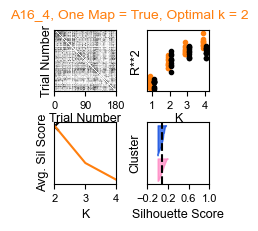

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

outperforms shuffle at optimal k = 3
stat = 55.0, p= 0.001


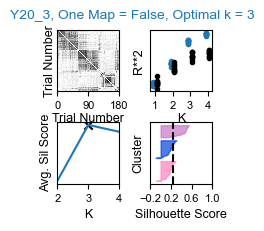

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

outperforms shuffle at optimal k = 4
stat = 55.0, p= 0.001


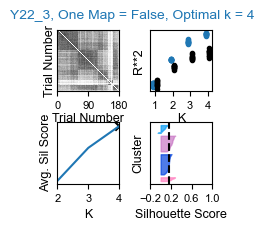

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

outperforms shuffle at optimal k = 2
stat = 55.0, p= 0.001


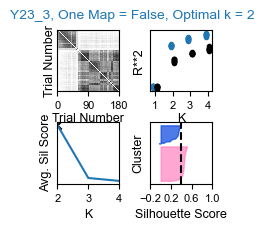

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [46]:
''' If you skipped the cell above, only plot Figure S4A & S4C examples. 

Y_unwrapped: matrix of shape m, n; m = n_trials & n = (nposbins * ncells)
W: first factor matrix. Has shape (m, rank) or n_trials, n_clusters (i.e. [0, 1] if map 1 and [1, 0] if map 0)
H: second factor matrix. Has shape (rank, n) or n_clusters, n_obs

Run time is about 5 - 15 minutes per session.

'''
possible_k = np.arange(2, 5, 1)
extended_k = np.arange(1,5,1)
colors = ['xkcd:pink','xkcd:blue','xkcd:orchid','xkcd:azure']
n_reps = 10 
alpha = 0.05

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/kmeans/' # adjust path

# if you want to visualize the quality of k selection for all sessions vs. just the examples in Figure S4A & C:
#example_mice = mice
#example_sessions = sessions

# if you want to visualize the quality of k selection for only the example sessions in Figure S4A & C
example_mice = ['Y23', 'Y20', 'Y22', 'A16']
example_sessions = ['092722_record3','090222_record4']

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
                
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if (len(gridcells) >= 10) and (m in example_mice) and (s in example_sessions):
            
            Y = d['FRtensorbacksorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            #Run k-means ten times and choose the k that most frequently most often maximizes the average silhouette score 
            silhouette_avgs = np.zeros((n_reps, len(possible_k)))
            for p in range(n_reps):
                sil_avgs = []
                for n in possible_k:     
                    # fit model and get params
                    model_kmeans = lvl_kmeans(n_components = n, n_restarts = 100)
                    model_kmeans.fit(Y_unwrapped)
                    W, _ = model_kmeans.factors
                    labels = []
                    for t in range(W.shape[0]):
                        mapid = np.where(W[t,:] == 1)[0]
                        labels = np.append(labels, mapid)
                    sil_avgs = np.append(sil_avgs, silhouette_score(Y_unwrapped, labels))
                silhouette_avgs[p,:] = sil_avgs
            
            #compare test R^2 vs. shuffle for k = 1-4
            # Run cross-validated k-means with speckled holdout pattern.
            km_train_scores = np.ones((4, n_reps))
            km_test_scores = np.ones((4, n_reps))

            for i, rank in enumerate(tdqm(extended_k)):
                model = lvl_kmeans(n_components=rank, n_restarts=100, maxiter=1000)
                km_train_scores[i], km_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_reps)

            # Run cross-validated k-means on shuffled/resampled dataset.
            shuff_km_train_scores = np.ones((4, n_reps))
            shuff_km_test_scores = np.ones((4, n_reps))

            for i, rank in enumerate(tdqm(extended_k)):
                model = lvl_kmeans(n_components=rank, n_restarts=100, maxiter=1000)
                shuff_km_train_scores[i], shuff_km_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_reps, resampler=RotationResampler())
            
            #Select optimal k, run KMeans with that k & store results, & plot to confirm quality of results
            if m in SM_aged_mice:
                col = 'C1'
            elif m in SM_MA_mice:
                col = 'C2'
            else:
                col = 'C0'
            
            SilN = possible_k[np.argmax(np.mean(silhouette_avgs, axis = 0))]
            model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
            model_kmeans.fit(Y_unwrapped)
            W, H = model_kmeans.factors
            Y_hat = model_kmeans.predict()
            score = model_kmeans.score(Y_unwrapped)
            d['kmeans'] = {}
            d['kmeans']['SilN'] = SilN
            d['kmeans']['W'] = W
            d['kmeans']['H'] = H
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['score'] = score
            
            #check & save whether if sig difference in the distribution of test R^2 real vs. shuffle data at optimal k:
            chosenkidx = np.where(extended_k == SilN)[0]
            res = stats.wilcoxon(km_test_scores[chosenkidx,:][0], shuff_km_test_scores[chosenkidx,:][0], alternative = 'greater')
            onemap = []
            if res.pvalue <= alpha:
                print('outperforms shuffle at optimal k = ' + str(SilN))
                print('stat = ' + str(np.round(res.statistic,2)) + ', p= ' + str(np.round(res.pvalue, 4)))
                onemap = np.append(onemap, [False, res.statistic, res.pvalue])
            else:
                print('does not outperform shuffle, probable one map session')
                print('stat = ' + str(np.round(res.statistic,2)) + ', p= ' + str(np.round(res.pvalue, 4)))
                onemap = np.append(onemap, [True, res.statistic, res.pvalue])

            #save boolean of whether the session was fit well by k > 1 (onemap = False)
            d['kmeans']['onemap'] = onemap
            #onemapfile = 'onemap' + m + '_' + s + '.npy'
            #np.save(save_folder + onemapfile, onemap)
            
            #get map labels & silhouette scores for samples & on average
            labels = []
            for t in range(W.shape[0]):
                mapid = np.where(W[t,:] == 1)[0]
                labels = np.append(labels, mapid)
            silhouette_avg = silhouette_score(Y_unwrapped, labels)
            samp_sil = silhouette_samples(Y_unwrapped, labels)

            ##SHOW GOODNESS OF CHOSEN as in Figures S4A & C
            #Plot silhouette averages + SEM over ten reps. 
            
            fig, ax = plt.subplots(2, 2, figsize = (2,2), sharey = False)
            plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
            fig.suptitle(str(m) + '_' + str(s[-1]) + ', One Map = ' + str(onemap[0].astype(bool)) + ', Optimal k = ' + str(SilN), color = col, fontsize = 10)

            #plot sparsely labeled sim matrix 
            sim = d['gridsimilaritybacksorted']
            im = ax[0,0].imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys', interpolation='none')
            ax[0,0].tick_params(which='major', labelsize=8)
            ax[0,0].set_ylabel('Trial Number', fontsize=9, labelpad=1)
            ax[0,0].set_xlabel('Trial Number', fontsize=9, labelpad=1)
            ax[0,0].set_yticks([])
            ax[0,0].set_xticks([0, 90, 180])
            ax[0,0].tick_params(labelsize = 8)

            #plot test R^2 vs. shuffle
            rax = np.tile(extended_k, (n_reps, 1)).T.ravel()
            ax[0,1].plot(rax-.1, km_test_scores.ravel(), '.', color = col, label = 'Data');
            ax[0,1].plot(rax+.1, shuff_km_test_scores.ravel(), '.k', label = 'Shuffle');
            ax[0,1].set_xticks(extended_k, labels = None)
            ax[0,1].set_ylabel("R**2", fontsize = 9)
            ax[0,1].set_xlabel('K', fontsize=9, labelpad = 1)
            ax[0,1].set_yticks([])
            #ax[0,1].legend(fontsize = 8)
            ax[0,1].tick_params(labelsize = 8)

            #plot of k selection criteria over n reps
            ax[1,0].plot(possible_k, np.mean(silhouette_avgs, axis = 0), color = col)
            ax[1,0].fill_between(possible_k, np.mean(silhouette_avgs, axis = 0) - stats.sem(silhouette_avgs, axis = 0),
                               np.mean(silhouette_avgs, axis = 0) + stats.sem(silhouette_avgs, axis = 0), facecolor = col, alpha = 0.2)
            ax[1,0].scatter(SilN, np.max(np.mean(silhouette_avgs, axis = 0)), color = 'k', marker = 'x')
            ax[1,0].set_xlim([2,4])
            ax[1,0].set_xticks(possible_k, labels = None)
            ax[1,0].set_yticks([])
            ax[1,0].set_ylabel('Avg. Sil Score', fontsize=9)
            ax[1,0].set_xlabel('K', fontsize=9)
            ax[1,0].tick_params(labelsize = 8)

            #plot of k selection criteria over n reps
            ax[1,1].set_xlim([-0.2, 1.0])
            ax[1,1].set_ylim([0, len(Y_unwrapped) + (SilN + 1) * 10])
            y_lower = 10
            for i in range(SilN):
                ith_cluster_silhouette_values = samp_sil[labels == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
                color = colors[i]
                ax[1,1].fill_betweenx(np.arange(y_lower, y_upper),0,
                    ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
                #ax[1,1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10  # 10 for the 0 samples
            ax[1,1].set_xlabel("Silhouette Score", fontsize = 9)
            ax[1,1].set_ylabel("Cluster", fontsize = 9)
            ax[1,1].axvline(x=silhouette_avg, color = "k", linestyle="--")
            ax[1,1].set_yticks([]) 
            ax[1,1].set_xticks([-0.2, 0.2, 0.6, 1.0])
            ax[1,1].tick_params(labelsize = 8)

            #plt.tight_layout()
            #plt.savefig(save_folder + m + '_' + s + '_chosenk.png', dpi=400, bbox_inches='tight')
            #plt.savefig(save_folder + m + '_' + s + '_chosenk.svg', dpi=400, bbox_inches='tight')
            plt.show()

In [47]:
''' After k optimization, load in results & perform K-means '''

kmeans_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/kmeans/' #adjust path to output above this 

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
                
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if len(gridcells) >= 10: 
            
            #Load stuff I have saved previously
            SilN_file = 'SilN_' + m + '_' + s + '.npy'
            SilN = np.load(kmeans_folder + SilN_file)
            
            #fit K-means
            Y = d['FRtensorbacksorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
            model_kmeans.fit(Y_unwrapped)
            W, H = model_kmeans.factors
            Y_hat = model_kmeans.predict()
            score = model_kmeans.score(Y_unwrapped)
            d['kmeans'] = {}
            d['kmeans']['SilN'] = SilN
            d['kmeans']['W'] = W
            d['kmeans']['H'] = H
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['score'] = score
            
            #load boolean to determine if I should keep k-means map in dataset (better than shuffle at chosen k)
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(kmeans_folder + onemapfile)
            d['kmeans']['onemap'] = onemap

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

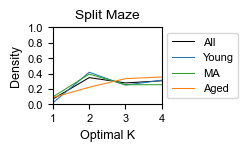


Optimal K KS:
A vs. Y CDF: Stat 0.12638888888888888, p=0.7872920372535105, sign=-1, loc=2.0
MA vs. Y CDF: Stat 0.07720588235294118, p=0.9938706983175754, sign=1, loc=1.0
A vs. MA CDF: Stat 0.17908496732026144, p=0.3716425042933553, sign=-1, loc=2.0


In [48]:
''' Plot Figure S4E (Right): Histogram of Optimal K for Split Maze Sessions'''
allks = []
optimalks = []
yk = []
mak = []
ak =[]
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]   
        
        if len(gridcells) >= 10:
            SilN = d['kmeans']['SilN']
            onemap = d['kmeans']['onemap'] # vector [one map boolean, WSR Stat, WSR P-Value]
            
            if onemap[0].astype(bool) == True:
                optimalks = np.append(optimalks, 1)
                allks = np.append(allks, 1)
                
                if m in SM_aged_mice:
                    ak = np.append(ak, 1)
                elif m in SM_MA_mice:
                    mak = np.append(mak, 1)
                else:
                    yk = np.append(yk, 1)
                
            else:
                optimalks = np.append(optimalks, SilN)
                allks = np.append(allks, SilN)
                
                if m in SM_aged_mice:
                    ak = np.append(ak, SilN)
                elif m in SM_MA_mice:
                    mak = np.append(mak, SilN)
                else:
                    yk = np.append(yk, SilN)
        else:
            allks = np.append(allks, np.nan)

#Plot half of Figure S4E
kbins = np.arange(1,5,1)
fig, ax = plt.subplots(figsize = (1.4,1))

allk, bin_edges = np.histogram(optimalks, bins = [1,2,3,4,5])
pdf = allk / sum(allk)
ax.plot(kbins, pdf, '-', linewidth = 0.75, alpha = 1, color = 'k', label = 'All')

y, bin_edges = np.histogram(yk, bins = [1,2,3,4,5])
pdf = y / sum(y)
ax.plot(kbins, pdf, '-', linewidth = 0.75, alpha = 1, color = 'C0', label = 'Young')

ma, bin_edges = np.histogram(mak, bins = [1,2,3,4,5])
pdf = ma / sum(ma)
ax.plot(kbins, pdf, '-', linewidth = 0.75, alpha = 1, color = 'C2', label = 'MA')

a, bin_edges = np.histogram(ak, bins = [1,2,3,4,5])
pdf = a / sum(a)
ax.plot(kbins, pdf, '-', linewidth = 0.75, alpha = 1, color = 'C1', label = 'Aged')
ax.tick_params(labelsize = 8)

plt.title('Split Maze', fontsize = 10)
plt.ylabel('Density', fontsize = 9)
plt.xlabel('Optimal K', fontsize = 9)
plt.xlim([1,4])
plt.xticks([1,2,3,4])
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.ylim([0,1])

ax.legend(bbox_to_anchor = (1,1), fontsize = 8)
#plt.savefig(save_folder + 'allsmoptimalkpdf.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'allsmoptimalkpdf.svg', dpi=400, bbox_inches='tight')
plt.show()

#run KS on optimal k distributions
print('\nOptimal K KS:')
res = stats.ks_2samp(ak,yk, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(mak,yk, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('MA vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(ak,mak, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. MA CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

In [60]:
''' Get remapping frequency by task phase across age groups'''

#get remap indices not requiring minimum map size
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10: 
            
            W = d['kmeans']['W']
            trials = np.arange(0, W.shape[0]-1)
            
            # define remaps
            remap_idx = np.asarray([])
            for w in range(W.shape[1]):
                remaps = np.where(np.abs(np.diff(W[:, w])))[0]
                remap_idx = np.append(remap_idx, remaps)
            remap_idx = np.unique(remap_idx)
            stable_idx = np.setdiff1d(trials,remap_idx)
            
            # save remap vs. stable indices
            d['remap_idx'] = [stable_idx.astype(int), remap_idx.astype(int)]

# get remapping frequency            
sblockremaps = []
saltremaps = []
gridmultimapsesh = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10: 
            onemap = d['kmeans']['onemap']
            
            if onemap[0].astype(bool) == True:
                gridmultimapsesh = np.append(gridmultimapsesh, False)
                print('skipping remapping assessment for one-map sesh ' + str(m) + ', ' + str(s))
                
                sblockremaps = np.append(sblockremaps, np.nan)
                saltremaps = np.append(saltremaps, np.nan)
                
            else:
                W = d['kmeans']['W']
                trials = np.arange(0, W.shape[0]-1)
                remap_idx = d['remap_idx'][1]
                gridmultimapsesh = np.append(gridmultimapsesh, True)

                # Load in left vs. right info
                trialinfo = raw.item().get('trialinfo')
                left = trialinfo['left']

                skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
                VRbackidx = d['VRbackidx'].astype(int)

                #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
                leftsort = left.copy()
                alt_idx = 140
                lefttail = left[alt_idx:]
                leftsort[alt_idx:] = lefttail[np.argsort(-1*lefttail, kind = 'stable')]

                context = []
                for i, t in enumerate(np.unique(skippedrawtrialfil[VRbackidx])):
                    context = np.append(context, leftsort[t.astype(int)])
                altcontextidx = np.where(np.diff(context) == 1.)[0][0] + 1 #index where alternation begins in context vectors

                #get n_switches & remap_idx for block only
                blockremap_idx = remap_idx[remap_idx < altcontextidx]
                sblockremaps = np.append(sblockremaps, blockremap_idx.shape[0]/len(trials[:altcontextidx]))
                   
                altremap_idx = remap_idx[remap_idx >= altcontextidx]
                saltremaps = np.append(saltremaps, altremap_idx.shape[0]/len(trials[altcontextidx:]))
        else:
            gridmultimapsesh = np.append(gridmultimapsesh, False)
            sblockremaps = np.append(sblockremaps, np.nan)
            saltremaps = np.append(saltremaps, np.nan)

skipping remapping assessment for one-map sesh A14, 083122_record2
skipping remapping assessment for one-map sesh A14, 090122_record3
skipping remapping assessment for one-map sesh A16, 090222_record4
skipping remapping assessment for one-map sesh A23, 021023_record2
skipping remapping assessment for one-map sesh MA4M, 103122_record2
skipping remapping assessment for one-map sesh MA4M, 110122_record3
skipping remapping assessment for one-map sesh MA5M, 110722_record2
skipping remapping assessment for one-map sesh MA6M, 110322_record5
skipping remapping assessment for one-map sesh MA8F, 111422_record2
skipping remapping assessment for one-map sesh Y24, 092022_record3


In [61]:
''' Find where nan and ignore for plotting '''
nan_idx10grid = np.where((gridmultimapsesh.astype(bool) == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind10grid = np.setdiff1d(y_sind, nan_idx10grid)
ma_sind10grid = np.setdiff1d(ma_sind, nan_idx10grid)
age_sind10grid = np.setdiff1d(age_sind, nan_idx10grid)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idx10grid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_young10grid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma10grid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old10grid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session10grid = [col_session_young10grid, col_session_ma10grid, col_session_old10grid] 

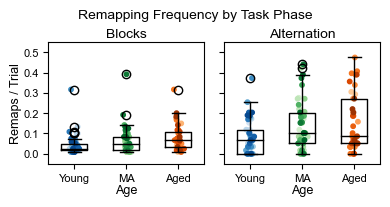

In [70]:
''' Plot Figure 3B, comparing remapping frequency across groups in the Split Maze'''

fig, ax = plt.subplots(1,2, figsize = (4,2.25), sharey = True)
fig.suptitle('Remapping Frequency by Task Phase', fontsize = 10, y = 0.9)

sblockremaps_tog = [sblockremaps[y_sind10grid], sblockremaps[ma_sind10grid],sblockremaps[age_sind10grid]]
labels = ['Young','MA','Aged']
w = 0.5
ax[0].boxplot(sblockremaps_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax[0].set_xlabel('Age', fontsize=9, labelpad=1)
ax[0].set_xticklabels(labels = labels, fontsize = 9)
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Remaps / Trial', fontsize=9, labelpad=1)
ax[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax[0].set_ylim([-0.05,0.55])
ax[0].set_title('Blocks', fontsize = 10, pad = 3)

for i in range(len(sblockremaps_tog)):
    y = sblockremaps_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[0].scatter(x, y, color = col_session10grid[i][:len(y)], edgecolors = col_session10grid[i][:len(y)], alpha = 1, s = 10)
    
saltremaps_tog = [saltremaps[y_sind10grid], saltremaps[ma_sind10grid],saltremaps[age_sind10grid]]
labels = ['Young','MA','Aged']
w = 0.5
ax[1].boxplot(saltremaps_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax[1].set_xlabel('Age', fontsize=9, labelpad=1)
#ax[1].set_ylabel('Remaps / Trial', fontsize=9, labelpad=1)
ax[1].set_xticklabels(labels = labels, fontsize = 8)
ax[1].tick_params(labelsize = 8)
ax[1].set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax[1].set_title('Alternation', fontsize = 10, pad = 3)

for i in range(len(saltremaps_tog)):
    y = saltremaps_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[1].scatter(x, y, color = col_session10grid[i][:len(y)], edgecolors = col_session10grid[i][:len(y)], alpha = 1, s = 10)
    
#ax[1].legend(handles = handles, labels = label_mice, ncol = 2, bbox_to_anchor=(1.2, 1))
plt.tight_layout()
#plt.savefig(save_folder + 'remappingfreq.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'remappingfreq.svg', dpi=400, bbox_inches='tight')
plt.show()

In [75]:
''' Perform Kruskal Wallis Test on Remapping Frequency in each Task Phase w/ Multiple Comparisons Correcition'''

print('n young, MA, aged sessions: ')
print(len(y_sind10grid), len(ma_sind10grid), len(age_sind10grid))

import statsmodels.api as sm
import scikit_posthocs as ph

H, p = stats.kruskal(sblockremaps[y_sind10grid],sblockremaps[ma_sind10grid],sblockremaps[age_sind10grid])
print('block remapping freq KW test H, p = ')
print(H, p)

print('\nmean ± SEM young block remap freq:')
print(str(np.mean(sblockremaps[y_sind10grid])) + ' ± '+ str(stats.sem(sblockremaps[y_sind10grid]))) 

print('mean ± SEM MA block remap freq:')
print(str(np.mean(sblockremaps[ma_sind10grid])) + ' ± '+ str(stats.sem(sblockremaps[ma_sind10grid]))) 

print('mean ± SEM age block remap freq:')
print(str(np.mean(sblockremaps[age_sind10grid])) + ' ± '+ str(stats.sem(sblockremaps[age_sind10grid]))) 

#make into dataframe
sex = list(animalmeta.Sex[mice_ind])
sexes = []
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        sexes = np.append(sexes, msex)
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind10grid,ma_sind10grid,age_sind10grid))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Sex = list(sexes[allidx])
Age_Group = list(seshage[allidx])
BlockFreq = list(sblockremaps[allidx])
AltFreq = list(saltremaps[allidx])

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, BlockFreq, AltFreq))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'AgeGroup','BlockFreq','AltFreq'])
df = df.dropna(axis = 0)

#Run Post Hoc Tests on Block Remapping Frequency
ph.posthoc_conover(df, val_col = 'BlockFreq', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions: 
47 46 41
block remapping freq KW test H, p = 
16.87870969346148 0.00021618958071442093

mean ± SEM young block remap freq:
0.04050528598480487 ± 0.007407073480638876
mean ± SEM MA block remap freq:
0.06413043478260871 ± 0.00968806825326724
mean ± SEM age block remap freq:
0.08001429608804062 ± 0.009832071945925986


,1.0,2.0,3.0
1.0,1.000000,0.021706,0.00009
2.0,0.021706,1.000000,0.07294
3.0,0.000090,0.072940,1.00000


In [76]:
#Run Post Hoc Tests on Alt Remapping Frequency
H, p = stats.kruskal(saltremaps[y_sind10grid],saltremaps[ma_sind10grid],saltremaps[age_sind10grid])
print('alt remapping freq KW test H, p = ')
print(H, p)

print('\nmean ± SEM young alt remap freq:')
print(str(np.mean(saltremaps[y_sind10grid])) + ' ± '+ str(stats.sem(saltremaps[y_sind10grid]))) 

print('mean ± SEM MA alt remap freq:')
print(str(np.mean(saltremaps[ma_sind10grid])) + ' ± '+ str(stats.sem(saltremaps[ma_sind10grid]))) 

print('mean ± SEM age alt remap freq:')
print(str(np.mean(saltremaps[age_sind10grid])) + ' ± '+ str(stats.sem(saltremaps[age_sind10grid]))) 

ph.posthoc_conover(df, val_col = 'AltFreq', group_col = 'AgeGroup', p_adjust = 'holm')

alt remapping freq KW test H, p = 
8.684265507967394 0.01300875412414525

mean ± SEM young alt remap freq:
0.07945258663153151 ± 0.012354929597282497
mean ± SEM MA alt remap freq:
0.1414268413773233 ± 0.017576085047912915
mean ± SEM age alt remap freq:
0.15069120391909321 ± 0.022064441502747147


,1.0,2.0,3.0
1.0,1.000000,0.021723,0.030709
2.0,0.021723,1.000000,0.848968
3.0,0.030709,0.848968,1.000000


Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.12740259876180926 -0.022766913763950635 -0.13778802801691417 -0.13529939923695852
P [Young, MA, Aged, All]: 
0.39344076437691755 0.8806205781248978 0.3902866990763826 0.11906577057105071


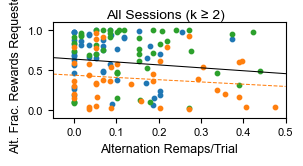

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.1864567300146632 0.07815997827847877 -0.0447956303412693 -0.10669848341465395
P [Young, MA, Aged, All]: 
0.20951466994614373 0.605638656370283 0.7809346834495456 0.21980041374047424


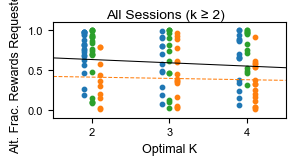

In [77]:
''' Plot relationship between alternation behavior and remapping frequency or optimal k (Figure S4I [left & right]) '''

### ALT Remaps/Trial vs. REQ RATES
#Linear regression
res = stats.linregress(saltremaps[y_sind10grid],reqalt_rates[y_sind10grid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(saltremaps[ma_sind10grid],reqalt_rates[ma_sind10grid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(saltremaps[age_sind10grid],reqalt_rates[age_sind10grid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind10grid,ma_sind10grid,age_sind10grid))
res = stats.linregress(saltremaps[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
        
fig, ax = plt.subplots(figsize = (3.00,1.25))
fig.suptitle('All Sessions (k ≥ 2)', fontsize = 10)
ax.scatter(saltremaps[y_sind10grid],reqalt_rates[y_sind10grid], color = 'C0', s = 10)
ax.scatter(saltremaps[ma_sind10grid],reqalt_rates[ma_sind10grid], color = 'C2', s = 10)
ax.scatter(saltremaps[age_sind10grid],reqalt_rates[age_sind10grid], color = 'C1', s = 10)
ax.set_xlabel('Alternation Remaps/Trial', fontsize = 9)
ax.set_ylabel('Alt. Frac. Rewards Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.05,0.5])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 0.75, color = 'k', label = 'All Ages')
#plt.savefig(save_folder + 'alldays_remapfreq_correlation_all.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'alldays_remapfreqcorrelation_all.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

### ALT Remaps/Trial vs. REQ RATES
#Linear regression
res = stats.linregress(allks[y_sind10grid],reqalt_rates[y_sind10grid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(allks[ma_sind10grid],reqalt_rates[ma_sind10grid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(allks[age_sind10grid],reqalt_rates[age_sind10grid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind10grid,ma_sind10grid,age_sind10grid))
res = stats.linregress(allks[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

fig, ax = plt.subplots(figsize = (3.00,1.25))
fig.suptitle('All Sessions (k ≥ 2)', fontsize = 10)
ax.scatter(allks[y_sind10grid] - 0.1,reqalt_rates[y_sind10grid], color = 'C0', s = 10)
ax.scatter(allks[ma_sind10grid],reqalt_rates[ma_sind10grid], color = 'C2', s = 10)
ax.scatter(allks[age_sind10grid] + 0.1,reqalt_rates[age_sind10grid], color = 'C1', s = 10)
ax.set_xlabel('Optimal K', fontsize = 9)
ax.set_ylabel('Alt. Frac. Rewards Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([1.5, 4.5])
ax.set_xticks([2,3,4])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 0.75, color = 'k', label = 'All Ages')
#plt.savefig(save_folder + 'alldays_kcorrelation_all.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'alldays_kcorrelation_all.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

# Setup for Figure S4D, E (left), F, H (Random Foraging)